# W261 Final Project

#### *Anusha Munjuluri, Arvindh Ganesan, Kim Vignola, Christina Papadimitriou*

### Notebook Set-up

In [165]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [3]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "final_project"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

## 1. Question Formulation

## 2. Algorithm Explanation

## 3. EDA & Discussion of Challenges

#### A. Data Loading

In [4]:
# take a look at the data
!head -n 1 data/train.txt

0	1	1	5	0	1382	4	15	2	181	1	2		2	68fd1e64	80e26c9b	fb936136	7b4723c4	25c83c98	7e0ccccf	de7995b8	1f89b562	a73ee510	a8cd5504	b2cb9c98	37c9c164	2824a5f6	1adce6ef	8ba8b39a	891b62e7	e5ba7672	f54016b9	21ddcdc9	b1252a9d	07b5194c		3a171ecb	c5c50484	e8b83407	9727dd16


In [5]:
# load the data
fullTrainRDD = sc.textFile('data/train.txt')
testRDD = sc.textFile('data/test.txt')

FIELDS = ['I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13',
          'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'C15','C16','C17','C18','C19','C20','C21','C22','C23','C24','C25','C26','Label']

In [6]:
# number of rows in train/test data
print(f"Number of records in train data: {fullTrainRDD.count()} ...")
print(f"Number of records in test data: {testRDD.count()} ...")

Number of records in train data: 45840617 ...
Number of records in test data: 6042135 ...


#### B. Creating Test and Train Split

In [9]:
# Generate 80/20 (pseudo)random train/test split 
trainRDD, heldOutRDD = fullTrainRDD.randomSplit([0.8,0.2], seed = 1)
print(f"... held out {heldOutRDD.count()} records for evaluation and assigned {trainRDD.count()} for training.")

... held out 9167871 records for evaluation and assigned 36672746 for training.


#### C. Preprocessing to get (features,label) RDD

In [371]:
# helper functions
def parse(line):
    """
    Map line --> tuple of (features, label)
    """
    fields = line.split('\t')
    features,label = fields[1:], fields[0]
    return (features, label)

def edit_data_types(line):
    """
    Map tuple of (features, label) --> tuple of (formated features, label)
    
    * '' is replaced with 'null'
    * numerical fields are converted to integers
    * make label column numeric
    """
    features, label = line[0], line[1]
    formated_features = []
    for i, value in enumerate(features):
        if value == '':
            formated_features.append(np.nan)
        else:
            if i < 13:
                formated_features.append(float(value)) 
            else:
                formated_features.append(value)
    return (formated_features, int(label))

In [372]:
# Making '' as np.nan and converting numerical features and output label to int
trainRDDCached = trainRDD.map(parse).map(edit_data_types).cache()

In [373]:
print(trainRDDCached.take(1))

[([1.0, 1.0, 5.0, 0.0, 1382.0, 4.0, 15.0, 2.0, 181.0, 1.0, 2.0, nan, 2.0, '68fd1e64', '80e26c9b', 'fb936136', '7b4723c4', '25c83c98', '7e0ccccf', 'de7995b8', '1f89b562', 'a73ee510', 'a8cd5504', 'b2cb9c98', '37c9c164', '2824a5f6', '1adce6ef', '8ba8b39a', '891b62e7', 'e5ba7672', 'f54016b9', '21ddcdc9', 'b1252a9d', '07b5194c', nan, '3a171ecb', 'c5c50484', 'e8b83407', '9727dd16'], 0)]


#### D. Extract 1000 records sample

In [14]:
# Get 1000 records as a sample
sample = trainRDDCached.map(lambda x: np.append(x[0], [x[1]])).takeSample(False, 1000)

In [121]:
# Making a pandas dataframe for 1000 samples from trainRDD
sample_df = pd.DataFrame(np.array(sample), columns = FIELDS)

# Shape 
print(sample_df.shape)

# Converting numeric columns and label to int
sample_df[['I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13']] = sample_df[['I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13']].apply(pd.to_numeric, errors='coerce')

(1000, 40)


#### E. Sample Dataset - Numerical Features Analysis

In [95]:
# part a - Look at summary statistics of numeric columns
sample_df.describe(exclude = [np.object])

,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13
count,552.000000,1000.00000,776.000000,764.000000,9.790000e+02,783.000000,961.000000,1000.000000,961.000000,552.000000,961.000000,227.000000,764.000000
mean,3.532609,98.11700,17.645619,7.231675,1.903143e+04,108.006386,20.854318,11.879000,108.335068,0.625000,2.808533,1.638767,7.781414
std,9.128585,347.54356,36.671788,8.898289,7.785810e+04,270.890530,129.932296,12.771902,225.154938,0.670042,6.826783,6.981765,10.232071
min,0.000000,-2.00000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.00000,2.000000,2.000000,3.950000e+02,8.000000,1.000000,2.000000,10.000000,0.000000,1.000000,0.000000,2.000000
50%,1.000000,3.00000,5.000000,4.000000,2.880000e+03,35.000000,3.000000,7.000000,42.000000,1.000000,1.000000,0.000000,4.000000
75%,3.000000,39.25000,16.000000,9.000000,1.017350e+04,98.500000,11.000000,18.000000,112.000000,1.000000,3.000000,1.000000,10.000000
max,115.000000,4393.00000,427.000000,73.000000,1.364227e+06,4301.000000,3107.000000,49.000000,3512.000000,4.000000,123.000000,68.000000,92.000000


In [144]:
# Take a subset of the dataframe with only numeric features
NUM_FIELDS = FIELDS[0:13]
sample_numeric = sample_df[NUM_FIELDS]
sample_numeric = sample_numeric.reindex(columns=NUM_FIELDS)

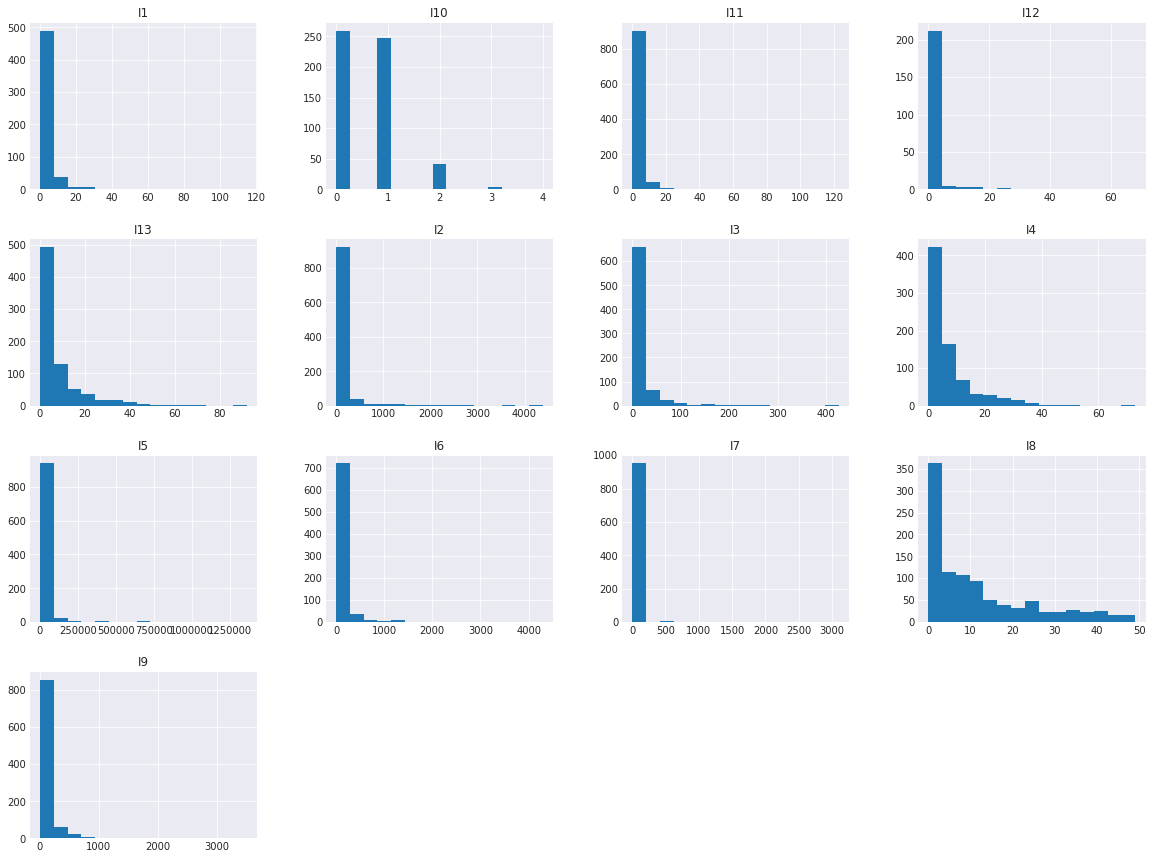

In [97]:
# part b - Take a look at histograms for each feature 
sample_numeric.hist(figsize=(20,15), bins=15)
plt.show()

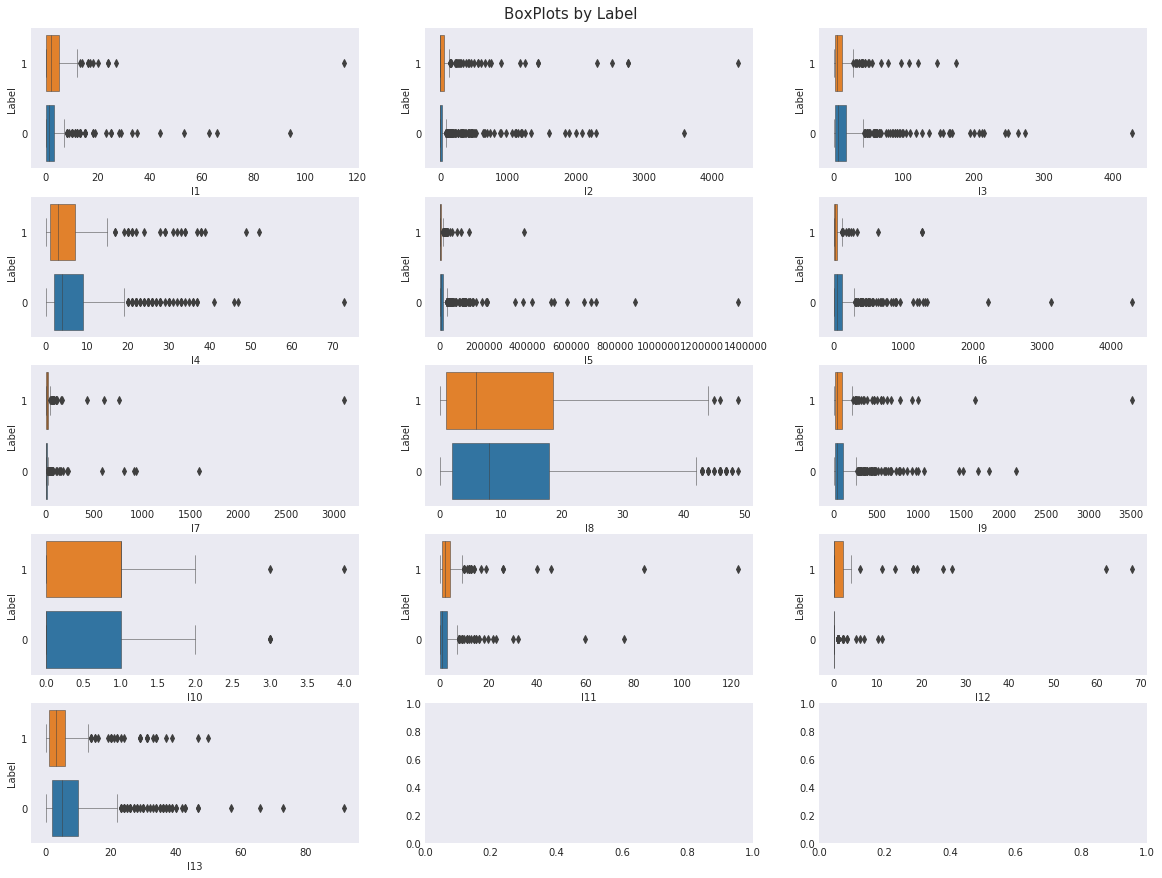

In [145]:
# part c -  plot boxplots of each feature vs. the outcome
fig, ax_grid = plt.subplots(5, 3, figsize=(20,15))
y = sample_df['Label']
for idx, feature in enumerate(NUM_FIELDS):
    x = sample_numeric[feature]
    sns.boxplot(x, y, ax=ax_grid[idx//3][idx%3], orient='h', linewidth=.5)
    ax_grid[idx//3][idx%3].invert_yaxis()
fig.suptitle("BoxPlots by Label", fontsize=15, y=0.9)
plt.show()

#### F. Sample Dataset - Categorical Numerical Features

In [104]:
# part a - Look at summary statistics of categorical columns (includes label column)
sample_df.describe(exclude = [np.number])

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,C18,C19,C20,C21,C22,C23,C24,C25,C26,Label
count,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
unique,49,203,782,660,23,7,705,39,2,602,...,390,141,4,734,6,12,477,27,360,2
top,05db9164,38a947a1,nan,nan,25c83c98,7e0ccccf,468a0854,0b153874,a73ee510,3b08e48b,...,e88ffc9d,nan,nan,nan,nan,32c7478e,3fdb382b,nan,nan,0
freq,471,109,34,34,675,380,12,576,898,228,...,37,427,427,34,767,440,54,427,427,749


#### G. Sample Dataset - Correlation between numerical features

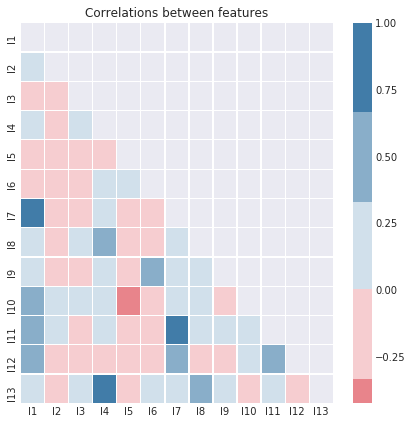

In [118]:
corr = sample_numeric.corr()
fig, ax = plt.subplots(figsize=(7, 7))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(10, 240, as_cmap=False)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.2)
plt.title("Correlations between features")
plt.show()

#### H - A Sample Dataset Analysis using PySpark DataFrames

In [334]:
sampleRDD = sc.parallelize(sample)
sampleDF = sampleRDD.map(lambda x: x.tolist()).toDF(FIELDS)
sampleDF = sampleDF.select([sampleDF.I1.cast("float"),sampleDF.I2.cast("float"),sampleDF.I3.cast("float"),sampleDF.I4.cast("float"),sampleDF.I5.cast("float"),
                            sampleDF.I6.cast("float"),sampleDF.I7.cast("float"),sampleDF.I8.cast("float"),sampleDF.I9.cast("float"),sampleDF.I10.cast("float"),
                            sampleDF.I11.cast("float"),sampleDF.I12.cast("float"),sampleDF.I13.cast("float"), 
                            sampleDF.C1, sampleDF.C2, sampleDF.C3, sampleDF.C4, sampleDF.C5, sampleDF.C6, sampleDF.C7, sampleDF.C8,sampleDF.C9,sampleDF.C10,
                            sampleDF.C11,sampleDF.C12,sampleDF.C13,sampleDF.C14, sampleDF.C15,sampleDF.C16, sampleDF.C17, sampleDF.C18, sampleDF.C19,
                            sampleDF.C20,sampleDF.C21,sampleDF.C22,sampleDF.C23,sampleDF.C24,sampleDF.C25,sampleDF.C26,sampleDF.Label])
sampleDF.head(1)

[Row(I1=0.0, I2=1113.0, I3=None, I4=None, I5=40124.0, I6=None, I7=None, I8=0.0, I9=None, I10=0.0, I11=None, I12=None, I13=None, C1='05db9164', C2='90081f33', C3='4534623a', C4='d3e9185c', C5='25c83c98', C6='fe6b92e5', C7='d130cbd1', C8='51d76abe', C9='a73ee510', C10='d422ad04', C11='9a422971', C12='91961646', C13='174e4cac', C14='b28479f6', C15='50b07d60', C16='c4f03387', C17='d4bb7bd8', C18='7da6ea7e', C19='nan', C20='nan', C21='af895155', C22='nan', C23='32c7478e', C24='359dd977', C25='nan', C26='nan', Label='0')]

In [369]:
# Get categorical columns most frequently occuring values
for field in list(set(FIELDS)-set(NUM_FIELDS)):
    freq = sampleDF.stat.freqItems([field], 0.1)
    print(freq.collect())

[Row(C26_freqItems=['nan', '49d68486', 'a68ab18c'])]
[Row(Label_freqItems=['1', '0'])]
[Row(C1_freqItems=['be589b51', '87552397', '8cf07265', '05db9164', '68fd1e64', '5a9ed9b0', '5bfa8ab5'])]
[Row(C10_freqItems=['3b08e48b', '935a36f0', '5168789b'])]
[Row(C7_freqItems=['6d490d7a', '4bbbd783', 'c4231034', '48ed6f4d', '9b98e9fc', '270fb9d7', 'b0da3612', 'dc7659bd', '99609181', 'c6c2ab11'])]
[Row(C9_freqItems=['a73ee510', '7cc72ec2'])]
[Row(C16_freqItems=['b688c8cc', 'b2844888', 'ba46c3a1', '9137a27f', 'b041b04a', '5fbf4a84', '57aba9d2', 'e2e2fcd9', '0b442a80', 'd1a4e968'])]
[Row(C6_freqItems=['6f6d9be8', '13718bbd', 'fbad5c96', 'nan', '3bf701e7', '7e0ccccf', 'fe6b92e5'])]
[Row(C25_freqItems=['ea9a246c', 'f0f449dd', 'cb079c2d', '445bbe3b', 'nan', '010f6491', '9b3e8820', 'e8b83407', '001f3601', '2bf691b1'])]
[Row(C21_freqItems=['2e9b1af0', '723b4dfd', 'b964dee0', '2754aaf1', 'ac498960', '9fb07dd2', 'deb9605d', 'eb0fc6f8', '4b1d1e4e', 'cf1c5dfc'])]
[Row(C19_freqItems=['efa3470f', '55dd3565',

In [368]:
# Get numeric features summary stats
summaryDF = sampleDF[[NUM_FIELDS]].summary()

# Round summary stats
import pyspark.sql.functions as func
for field in NUM_FIELDS:
    summaryDF = summaryDF.withColumn(field, func.round(summaryDF[field], 2))

# Display summary stats
summaryDF.show()

############################# OLD CODE ################################

# IF SAMPLE DF NUMERIC COLUMNS ARE NOT CAST AS FLOAT - NEED TO USE BELOW

#def blank_as_null(x):
#    return when(col(x) != "None", col(x)).otherwise(None)

#for field in NUM_FIELDS:
    #sampleDF[[field]].summary().show()
    #subsetDF = sampleDF[[field]] # create a subset DF with column needed
    #subsetDFEmptyReplaced = subsetDF.withColumn(subsetDF.columns[0], blank_as_null(subsetDF.columns[0])) # remove 'nan' rows
    #subsetDFEmptyReplaced.summary().show() 

+-------+-----+------+-----+-----+---------+------+------+------+------+-----+-----+-----+-----+
|summary|   I1|    I2|   I3|   I4|       I5|    I6|    I7|    I8|    I9|  I10|  I11|  I12|  I13|
+-------+-----+------+-----+-----+---------+------+------+------+------+-----+-----+-----+-----+
|  count|552.0|1000.0|776.0|764.0|    979.0| 783.0| 961.0|1000.0| 961.0|552.0|961.0|227.0|764.0|
|   mean| 3.53| 98.12|17.65| 7.23| 19031.43|108.01| 20.85| 11.88|108.34| 0.63| 2.81| 1.64| 7.78|
| stddev| 9.13|347.54|36.67|  8.9|  77858.1|270.89|129.93| 12.77|225.15| 0.67| 6.83| 6.98|10.23|
|    min|  0.0|  -2.0|  0.0|  0.0|      0.0|   0.0|   0.0|   0.0|   0.0|  0.0|  0.0|  0.0|  0.0|
|    25%|  0.0|   0.0|  2.0|  2.0|    393.0|   8.0|   1.0|   2.0|  10.0|  0.0|  1.0|  0.0|  2.0|
|    50%|  1.0|   3.0|  5.0|  4.0|   2880.0|  35.0|   3.0|   7.0|  42.0|  1.0|  1.0|  0.0|  4.0|
|    75%|  3.0|  39.0| 16.0|  9.0|  10177.0|  99.0|  11.0|  18.0| 112.0|  1.0|  3.0|  1.0| 10.0|
|    max|115.0|4393.0|427.0| 7

#### H - B TrainRDD Dataset Analysis using PySpark DataFrames

In [ ]:
trainDF = trainRDDCached.map(lambda x: np.append(x[0], [x[1]])).map(lambda x: x.tolist()).toDF(FIELDS)
trainDF = trainDF.select([trainDF.I1.cast("float"),trainDF.I2.cast("float"),trainDF.I3.cast("float"),trainDF.I4.cast("float"),trainDF.I5.cast("float"),
                            trainDF.I6.cast("float"),trainDF.I7.cast("float"),trainDF.I8.cast("float"),trainDF.I9.cast("float"),trainDF.I10.cast("float"),
                            trainDF.I11.cast("float"),trainDF.I12.cast("float"),trainDF.I13.cast("float"), 
                            trainDF.C1, trainDF.C2, trainDF.C3, trainDF.C4, trainDF.C5, trainDF.C6, trainDF.C7, trainDF.C8,trainDF.C9,trainDF.C10,
                            trainDF.C11,trainDF.C12,trainDF.C13,trainDF.C14, trainDF.C15,trainDF.C16, trainDF.C17, trainDF.C18, trainDF.C19,
                            trainDF.C20,trainDF.C21,trainDF.C22,trainDF.C23,trainDF.C24,trainDF.C25,trainDF.C26,trainDF.Label])
# Get one row
trainDF.head(1)

# Get categorical columns most frequently occuring values
for field in list(set(FIELDS)-set(NUM_FIELDS)):
    freq = trainDF.stat.freqItems([field], 0.1)
    print(freq.collect())
    
# Get numeric features summary stats    
summaryDF = trainDF[[NUM_FIELDS]].summary()

# Round summary stats
import pyspark.sql.functions as func
for field in NUM_FIELDS:
    summaryDF = summaryDF.withColumn(field, func.round(summaryDF[field], 2))

# Display summary stats
summaryDF.show()

#### I. Getting count of numerical features bucket wise 

In [404]:
def bucket_values(line):
    """
    Map tuple of (features, label) --> tuple of (formated features, label)
    
    * '' is replaced with 'null'
    * numerical fields are converted to integers
    * make label column numeric
    """
    features, label = line[0], line[1]
    formated_features = []
    for i, value in enumerate(features[0:13]):
        if value == '':
            formated_features.append("NA")
        else:
            value = float(value)
            if value < 0:
                formated_features.append("A")
            elif value >=0 and value < 100 :
                formated_features.append("B")
            elif value >=100 and value < 500:
                formated_features.append("C")
            elif value >=500 and value < 1000:
                formated_features.append("D")
            elif value >=1000 and value < 5000:
                formated_features.append("E")
            elif value >=5000 and value < 10000:
                formated_features.append("F")
            else: #value >= 10000
                formated_features.append("G")
    return formated_features

In [388]:
sampleRDD = trainRDDCached.takeSample(False, 100).cache()

In [405]:
bucketRDD = sc.parallelize(sampleRDD).map(bucket_values).cache()

In [407]:
countPandasDF = pd.DataFrame(columns = ['NA', 'A', 'B', 'C', 'D', 'E', 'F', 'G'], index = NUM_FIELDS)
countPandasDF

for i, field in enumerate(NUM_FIELDS):
    countsRDD = bucketRDD.map(lambda x: (x[i],1)).reduceByKey(sum)
    countPandasDF.iloc[[field]] = np.array(countsRDD.collect())

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 774.0 failed 1 times, most recent failure: Lost task 0.0 in stage 774.0 (TID 6774, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 230, in main
    process()
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 225, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/anaconda/lib/python3.6/site-packages/pyspark-2.3.1-py3.6.egg/pyspark/rdd.py", line 2457, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/opt/anaconda/lib/python3.6/site-packages/pyspark-2.3.1-py3.6.egg/pyspark/rdd.py", line 2457, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/opt/anaconda/lib/python3.6/site-packages/pyspark-2.3.1-py3.6.egg/pyspark/rdd.py", line 370, in func
    return f(iterator)
  File "/opt/anaconda/lib/python3.6/site-packages/pyspark-2.3.1-py3.6.egg/pyspark/rdd.py", line 1876, in combineLocally
    merger.mergeValues(iterator)
  File "/opt/spark/python/lib/pyspark.zip/pyspark/shuffle.py", line 239, in mergeValues
    d[k] = comb(d[k], v) if k in d else creator(v)
  File "/opt/anaconda/lib/python3.6/site-packages/pyspark-2.3.1-py3.6.egg/pyspark/util.py", line 55, in wrapper
    return f(*args, **kwargs)
TypeError: 'int' object is not iterable

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:298)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:438)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:421)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:252)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:1126)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:1132)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:125)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1602)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1590)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1589)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1589)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1823)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1772)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1761)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2034)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2055)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2074)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2099)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:939)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:938)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:162)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.GeneratedMethodAccessor394.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 230, in main
    process()
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 225, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/anaconda/lib/python3.6/site-packages/pyspark-2.3.1-py3.6.egg/pyspark/rdd.py", line 2457, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/opt/anaconda/lib/python3.6/site-packages/pyspark-2.3.1-py3.6.egg/pyspark/rdd.py", line 2457, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/opt/anaconda/lib/python3.6/site-packages/pyspark-2.3.1-py3.6.egg/pyspark/rdd.py", line 370, in func
    return f(iterator)
  File "/opt/anaconda/lib/python3.6/site-packages/pyspark-2.3.1-py3.6.egg/pyspark/rdd.py", line 1876, in combineLocally
    merger.mergeValues(iterator)
  File "/opt/spark/python/lib/pyspark.zip/pyspark/shuffle.py", line 239, in mergeValues
    d[k] = comb(d[k], v) if k in d else creator(v)
  File "/opt/anaconda/lib/python3.6/site-packages/pyspark-2.3.1-py3.6.egg/pyspark/util.py", line 55, in wrapper
    return f(*args, **kwargs)
TypeError: 'int' object is not iterable

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:298)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:438)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:421)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:252)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:1126)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:1132)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:125)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


In [ ]:
countPandasDF
# Take a look at histograms for each feature 
sample_numeric.hist(figsize=(20,15), bins=15, label=['NA', '<0', '0-100', '100-500', '500-1000', '1000-5000', '5000-10000', '>10000'])
plt.show()

### EDA

#### Dataset Introduction 

The training dataset consists of a portion of Criteo's traffic over a period of 7 days. Each row corresponds to a display ad served by Criteo and the first column indicates whether this ad has been clicked or not. The positive (clicked) and negatives (non-clicked) examples have both been subsampled (but at different rates) in order to reduce the dataset size.

There are 13 features taking integer values (mostly count features) and 26 categorical features. The values of the categorical features have been hashed onto 32 bits for anonymization purposes. The semantic of these features is undisclosed. Some features may have missing values.

The rows are chronologically ordered. The test set is computed in the same way as the training set but it 
corresponds to events on the day following the training period and does not have the label column.

#### Train File:

* Number of rows: 45840617 (~ 45 million)
2. Number of columns: 40 Columns
    -  13 Numerical Features I1-I13
    -  26 Categorical Features C1-C26
    -  1 Label Column - 0 or 1  
3. **Numerical Columns Analysis**:
4. **Categorical Columns Analysis**:
5. **Output Column Analysis**:
    -  Binary variable with values as 0 or 1 
    -  0 - user clicked on the ad, 1 - user did not click on the ad

#### Test File:

1. Number of rows: 6042135 (~ 6 million)
2. Number of columns: 
3. Numerical Columns Analysis:
4. Categorical Columns Analysis:
5. Output Column Analysis:
    

## 4. Algorithm Implementation

## 5. Application of Course Concepts